# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')
con = sqlite3.connect('/content/drive/My Drive/Asgn/database.sqlite')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 limit 300000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (300000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(228569, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

76.18966666666667

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(228567, 10)


1    192377
0     36190
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
I have a pitbull 3years old and my wife has 2 pugs 7months and a 1 year old, they are all best friends. I bought the dental Dinosaur, because my pitbull will chew up any toy in 5 minutes and they were made of a very hard plastic.I am very amazed how long they have lasted and all 3 dogs love to chew on them.
Very effective at getting rid of indoor flea problem (moderate severity) in the Midwest.  Light smell - less intense & less

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
I have a pitbull 3years old and my wife has 2 pugs 7months and a 1 year old, they are all best friends. I bought the dental Dinosaur, because my pitbull will chew up any toy in 5 minutes and they were made of a very hard plastic.I am very amazed how long they have lasted and all 3 dogs love to chew on them.
Very effective at getting rid of indoor flea problem (moderate severity) in the Midwest.  Light smell - less intense & less chemically smell than Raid Flea Kil

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Very effective at getting rid of indoor flea problem (moderate severity) in the Midwest.  Light smell - less intense & less chemically smell than Raid Flea Killer Plus Room & Carpet Spray.  Do not yet know how well this product works on eliminating fleas long term as it is only been a couple of weeks.  Dog had no problem using his dog bed after his bed was sprayed & aired.<br /><br />If you need a fine mist & are covering a small area (e.g., just pet bed/furniture), this spray nozzle could be better (Raid Flea Killer Plus nozzle allows for more even mist as per instructions).  The sprayer of my first can was defective squirting splatters/gobs of foam randomly rather than a mist (e.g., splattering foam gobs onto the walls 10 inches away rather than the carpet even while can was pointed down at the ground).  Had to get a 2nd can (the seller sent new can right away at no charge).  I prefer the flea spray for covering carpets, rooms & pet furniture to the flea powder/granules as some peopl

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Very effective at getting rid of indoor flea problem moderate severity in the Midwest Light smell less intense less chemically smell than Raid Flea Killer Plus Room Carpet Spray Do not yet know how well this product works on eliminating fleas long term as it is only been a couple of weeks Dog had no problem using his dog bed after his bed was sprayed aired br br If you need a fine mist are covering a small area e g just pet bed furniture this spray nozzle could be better Raid Flea Killer Plus nozzle allows for more even mist as per instructions The sprayer of my first can was defective squirting splatters gobs of foam randomly rather than a mist e g splattering foam gobs onto the walls 10 inches away rather than the carpet even while can was pointed down at the ground Had to get a 2nd can the seller sent new can right away at no charge I prefer the flea spray for covering carpets rooms pet furniture to the flea powder granules as some people experience breathing issues from the fine ai

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 228567/228567 [01:20<00:00, 2855.48it/s]


In [0]:
preprocessed_reviews[1500]

'effective getting rid indoor flea problem moderate severity midwest light smell less intense less chemically smell raid flea killer plus room carpet spray not yet know well product works eliminating fleas long term couple weeks dog no problem using dog bed bed sprayed aired need fine mist covering small area e g pet bed furniture spray nozzle could better raid flea killer plus nozzle allows even mist per instructions sprayer first defective squirting splatters gobs foam randomly rather mist e g splattering foam gobs onto walls inches away rather carpet even pointed ground get seller sent new right away no charge prefer flea spray covering carpets rooms pet furniture flea powder granules people experience breathing issues fine airborne particles powder granules long vacuuming'

In [0]:
final['cleanedText']=preprocessed_reviews

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [0]:
X1=final['cleanedText']

# [4] Featurization

## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=2000)
tf_idf_vect.fit(X1)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X1)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able find', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'according', 'acid', 'across', 'actual']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (228567, 2000)
the number of unique words including both unigrams and bigrams  2000


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
top_feat = tf_idf_vect.get_feature_names()

### [5.2] Calulation of Co-occurrence matrix

In [0]:
# Please write all the code with proper documentation

In [0]:
#https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix/41663359
#https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781783989485/1/ch01lvl1sec21/using-truncated-svd-to-reduce-dimensionality
m = np.zeros([length,length]) # n is the count of all words
def cal_occ(sentence,m):
    for i,word in enumerate(sentence):
        for j in range(max(i-window,0),min(i+window,length)):
             m[word,sentence[j]]+=1
for sentence in X:
    cal_occ(sentence, m)

In [0]:
#https://linguistics.stackexchange.com/questions/3641/how-to-calculate-the-co-occurrence-between-two-words-in-a-window-of-text
#https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix/41663359
#https://stackoverflow.com/questions/35562789/how-do-i-calculate-a-word-word-co-occurrence-matrix-with-sklearn
#https://www.sciencedirect.com/topics/engineering/cooccurrence-matrix

from tqdm import tqdm
n_neighbor = 5
Cv_matrix = np.zeros((2000,2000))
for row in tqdm(X1.values):
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        if word in top_feat:
            for j in range(max(index-n_neighbor,0),min(index+n_neighbor,len(words_in_row)-1) + 1):
                if words_in_row[j] in top_feat:
                    Cv_matrix[top_feat.index(word),top_feat.index(words_in_row[j])] += 1
                else:
                    pass
        else:
            pass

100%|██████████| 228567/228567 [50:23<00:00, 75.59it/s]


### [5.3] Finding optimal value for number of components (n) to be retained.

In [0]:
# Please write all the code with proper documentation

In [0]:
#https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
#https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
#from search
def plotCumulativeVariance(self, co_occurrence_matrix):
        #Applying TruncatedSVD
        from sklearn.decomposition import TruncatedSVD
        max_features = co_occurrence_matrix.shape[1]-1
        svd = TruncatedSVD(n_components=max_features)
        svd_data = svd.fit_transform(co_occurrence_matrix)
        percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_)
        cum_var_explained = np.cumsum(percentage_var_explained)
        # Plot the TrunvatedSVD spectrum
        plt.figure(1, figsize=(6, 4))
        plt.clf()
        plt.plot(cum_var_explained, linewidth=2)
        plt.axis('tight')
        plt.grid()
        plt.xlabel('n_components')
        plt.ylabel('Cumulative_explained_variance')
        plt.title("Cumulative_explained_variance VS n_components")
        plt.show()

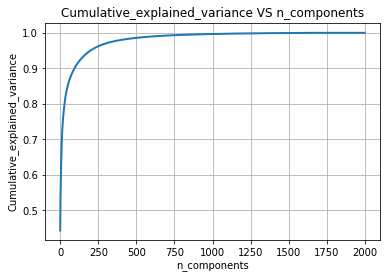

In [0]:
plotCumulativeVariance(6,Cv_matrix)

### [5.4] Applying k-means clustering

In [0]:
# Please write all the code with proper documentation

In [0]:
#Code from previous assignment
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
k1 = [2,3,4,5,6,7,8,9,10]
inertia = []
for i in k1:
    kmeans1 = KMeans(n_clusters=i, n_jobs=-1,init='k-means++', max_iter=100, n_init=1)
    kmeans1.fit(final_tf_idf)
    inertia.append(kmeans1.inertia_)

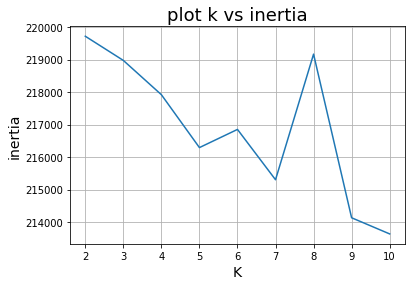

In [0]:
# Draw Loss VS K values plot
plt.plot(k1, inertia)
plt.xlabel('K',size=14)
plt.ylabel('inertia',size=14)
plt.title('plot k vs inertia',size=18)
plt.grid()
plt.show()

In [0]:
optk=5
kmeans1 = KMeans(n_clusters=optk, n_jobs=-1,init='k-means++', max_iter=100, n_init=1)
kmeans1.fit(final_tf_idf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=5, n_init=1, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
print("Top terms per cluster:")
order_centroids = kmeans1.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vect.get_feature_names()
for i in range(optk):
    print ("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
      #print("Cluster %d:" % terms[ind], end=" ")
        print (' %s' % terms[ind],)
       
    print()

Top terms per cluster:
Cluster 0:
 tea
 green
 green tea
 not
 teas
 flavor
 drink
 like
 good
 taste

Cluster 1:
 coffee
 cup
 not
 like
 flavor
 good
 cups
 taste
 strong
 great

Cluster 2:
 not
 product
 good
 great
 like
 taste
 one
 love
 would
 amazon

Cluster 3:
 dog
 food
 dogs
 treats
 cat
 not
 loves
 cats
 treat
 dog food

Cluster 4:
 use
 not
 water
 sauce
 great
 free
 like
 mix
 gluten
 good



### [5.5] Wordclouds of clusters obtained in the above section

In [0]:
# Please write all the code with proper documentation

In [0]:
#Plot each cluster features in a cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
def plot_cluster_cloud1(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(3, 1, figsize = (10, 15))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 30)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

In [0]:
features = tf_idf_vect.get_feature_names()
coef = kmeans1.cluster_centers_


5


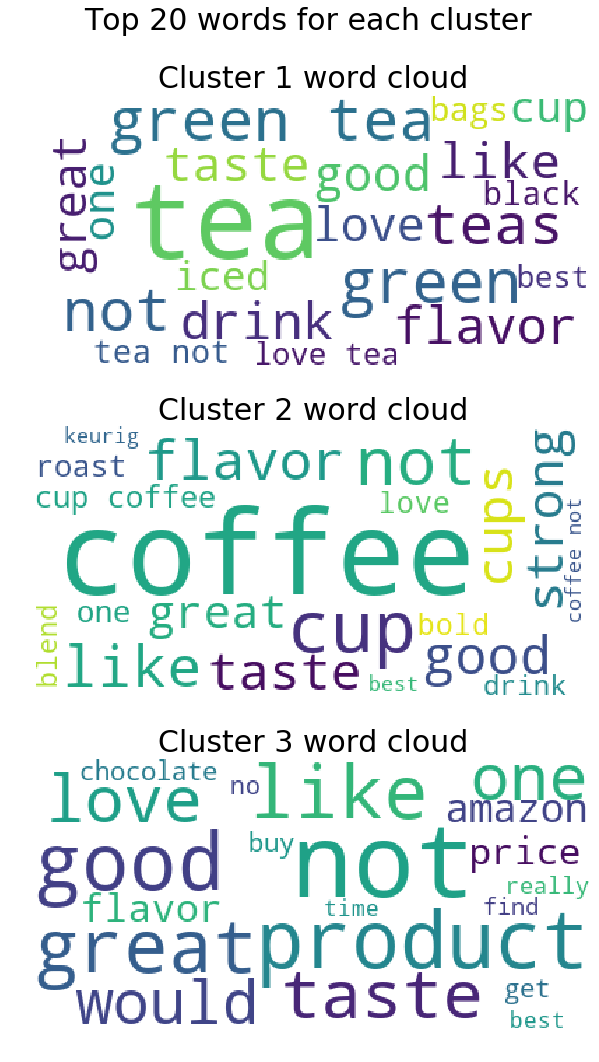

In [0]:
plot_cluster_cloud1(features, coef)

### [5.6] Function that returns most similar words for a given word.

In [0]:
# Please write all the code with proper documentation

In [0]:
#https://www.programcreek.com/python/example/100424/sklearn.metrics.pairwise.cosine_similarity
#http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
from sklearn.metrics.pairwise import cosine_similarity
def similar_word_10(word):
    similarity = cosine_similarity(Cv_matrix)
    word_vect = similarity[top_feat.index(word)]
    print("Similar Word to",word)
    index = word_vect.argsort()[::-1][1:11]
    for j in range(len(index)):
        print((j+1),"Word",top_feat[index[j]] ,"is similar to",word,"\n")

In [0]:
similar_word_10(top_feat[1])

Similar Word to able find
1 Word funny is similar to able find 

2 Word friend is similar to able find 

3 Word friends is similar to able find 

4 Word front is similar to able find 

5 Word frozen is similar to able find 

6 Word fructose is similar to able find 

7 Word fructose corn is similar to able find 

8 Word fruit is similar to able find 

9 Word fruits is similar to able find 

10 Word fruity is similar to able find 



# [6] Conclusions

In [0]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.

# **Observations**
 The datastae is vectorised using TFIDF. Co-occurence matrix is calculated. Truncated SVD is applied.Optimal value is ranging from 0.9 to 1 near to 150 components.Used 100K data points for modelling.
 
 K-means clustering is applied to identify clusters. Optimal cluster number obtained using elbow plot. Word cloud is plotted. Similar words are printed.